In [1]:
from pathlib import Path
import shutil
from itertools import combinations
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

from plots import heatmap, annotate_heatmap

%matplotlib inline

In [2]:
def import_data(fn):
    data = np.loadtxt(fn)
    inputs, labels = data[:, 1:], data[:, 0]
    return inputs, labels

X, Y = import_data('zipcombo.dat')
n_classes = 10

In [3]:
class BaseKernel:

    def __init__(self, X1, X2=None):
        self.base_kernel_matrix = self.base_kernel(X1, X2 if X2 is not None else X1)

    def base_kernel(self, a, b):
        raise NotImplementedError
    
    def indices(self, row_indices, col_indices):
        if row_indices is None:
            row_indices = np.arange(self.base_kernel_matrix.shape[0])
        if col_indices is None:
            col_indices = np.arange(self.base_kernel_matrix.shape[1])
        return np.ix_(row_indices, col_indices)
    
    def kernel(self, hparam, row_indices=None, col_indices=None):
        raise NotImplementedError

In [4]:
class PolynomialKernel(BaseKernel):

    def __init__(self, X1, X2=None):
        super().__init__(X1, X2)

    def base_kernel(self, a, b):
        dot_products = np.dot(a, b.T)
        return dot_products
    
    def kernel(self, hparam, row_indices=None, col_indices=None):
        indices = self.indices(row_indices, col_indices)
        kernel_matrix = np.power(self.base_kernel_matrix[indices], hparam)
        return kernel_matrix
    
full_kernel = PolynomialKernel(X)

In [5]:
def init_coefs(n_classifiers, train_size):
    coefs = np.zeros((n_classifiers, train_size))
    return coefs
    
def predict(coefs, kernel_values):
    predictions = np.dot(coefs, kernel_values)
    return predictions

def sign(x):
    return np.where(x <= 0., -1., 1.)

In [6]:
def train(train_kernel, train_y, coefs, n_epochs=1):
    
    mistakes = [0 for _ in range(n_epochs)]
    for epoch in range(n_epochs):
        for i in range(train_y.size):
            features, y = train_kernel[i], train_y[i]
            predictions = predict(coefs, features); argmax = np.argmax(predictions)
            if argmax != y:
                mistakes[epoch] += 1
            labels = np.full(coefs.shape[0], -1.); labels[int(y)] = 1.
            updates = np.where(labels*predictions <= 0., sign(predictions), 0.)
            coefs[:, i] -= updates
    return coefs, mistakes

def test(test_kernel, test_y, coefs, return_cm=False):

    mistakes = 0
    if return_cm:
        confusion_matrix = np.zeros((coefs.shape[0], coefs.shape[0]))
    for i in range(test_y.size):
        features, y = test_kernel[i], test_y[i]
        predictions = predict(coefs, features); argmax = np.argmax(predictions)
        if argmax != y:
            mistakes += 1
        if return_cm:
            confusion_matrix[int(y), argmax] += 1

    return mistakes, (confusion_matrix if return_cm else None)

### Demo

In [7]:
def execute_run(train_x, train_y, test_x, test_y, d=3, n_classes=3, n_epochs=3):

    train_kernel = PolynomialKernel(train_x).kernel(d)
    test_kernel = PolynomialKernel(test_x, train_x).kernel(d)
    coefs = init_coefs(n_classes, train_x.shape[0])
    for i in range(1, n_epochs+1):
        coefs, train_mistakes = train(train_kernel, train_y, coefs, n_epochs=1)
        test_mistakes, _ = test(test_kernel, test_y, coefs, return_cm=False)
        print(f'Epoch {i} - {train_mistakes[-1]} mistakes out of {train_x.shape[0]} items on training set, test error is {test_mistakes/test_x.shape[0]*100:.3f}%.')
    
    return coefs, train_mistakes[0], test_mistakes

In [8]:
train_x, train_y = import_data('dtrain123.dat')
test_x, test_y = import_data('dtest123.dat')

coefs, *_ = execute_run(train_x, train_y-1, test_x, test_y-1, d=3, n_classes=3, n_epochs=3)

Epoch 1 - 15 mistakes out of 329 items on training set, test error is 3.509%.
Epoch 2 - 3 mistakes out of 329 items on training set, test error is 2.851%.
Epoch 3 - 0 mistakes out of 329 items on training set, test error is 2.632%.


### Question 1

In [9]:
n_classifiers = n_classes

In [10]:
def question_1(n_runs, hparams, n_epochs):

    error_rates = {'train': np.zeros((n_runs, len(hparams))), 'test': np.zeros((n_runs, len(hparams)))}

    for i in tqdm(range(len(hparams))):

        hparam = hparams[i]
        full_kernel_d = full_kernel.kernel(hparam)

        for run in range(n_runs):

            train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
            train_kernel, test_kernel = full_kernel_d[np.ix_(train_indices, train_indices)], full_kernel_d[np.ix_(test_indices, train_indices)]
            train_y, test_y = Y[train_indices], Y[test_indices]

            coefs = init_coefs(n_classifiers, train_indices.size)
            coefs, train_mistakes = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
            test_mistakes, _ = test(test_kernel, test_y, coefs, return_cm=False)
            
            error_rates['train'][run, i] = train_mistakes[-1]/train_y.size
            error_rates['test'][run, i] = test_mistakes/test_y.size

    error_rates['train'] = [f'{100*m:.3f} ± {100*s:.3f}' for m, s in zip(np.mean(error_rates['train'], axis=0), np.std(error_rates['train'], axis=0))]
    error_rates['test']  = [f'{100*m:.3f} ± {100*s:.3f}' for m, s in zip(np.mean(error_rates['test'], axis=0),  np.std(error_rates['test'], axis=0))]

    return error_rates

In [11]:
n_runs, n_epochs = 20, 3
ds = range(1, 8)
error_rates = question_1(n_runs=n_runs, hparams=ds, n_epochs=n_epochs)

df = pd.DataFrame(data=zip(*error_rates.values()), index=ds, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Degree')
df

  0%|          | 0/7 [00:00<?, ?it/s]

,Train error (%),Test error (%)
Degree,,
1,8.823 ± 0.190,10.032 ± 1.510
2,1.870 ± 0.124,4.285 ± 0.519
3,0.758 ± 0.104,3.433 ± 0.424
4,0.424 ± 0.069,3.280 ± 0.326
5,0.294 ± 0.066,2.847 ± 0.469
6,0.210 ± 0.051,2.933 ± 0.409
7,0.188 ± 0.055,3.008 ± 0.336


### Questions 2 and 3

In [12]:
def question_2(n_runs, n_splits, hparams, n_epochs, return_cm=True):

    kfold = KFold(n_splits=n_splits, shuffle=True)

    confusion_matrix = [None for _ in range(n_runs)]
    results = {'hparam_star': np.zeros((n_runs,)), 'test_error': np.zeros((n_runs,))}

    for run in tqdm(range(n_runs)):
        
        train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
        
        val_errors = np.zeros((len(hparams), kfold.get_n_splits()))
        for i, hparam in enumerate(hparams):
            full_kernel_d = full_kernel.kernel(hparam)
            for fold, (train_fold, val_fold) in enumerate(kfold.split(train_indices)):
                train_kernel, val_kernel = full_kernel_d[np.ix_(train_fold, train_fold)], full_kernel_d[np.ix_(val_fold, train_fold)]
                train_y, val_y = Y[train_fold], Y[val_fold]
                coefs = init_coefs(n_classifiers, train_fold.size)
                coefs, _ = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
                val_mistakes, _ = test(val_kernel, val_y, coefs, return_cm=False)
                val_errors[i, fold] = val_mistakes/val_y.size
        val_errors = val_errors.mean(axis=1)
        hparam_star = hparams[np.argmin(val_errors)]; results['hparam_star'][run] = hparam_star

        full_kernel_d = full_kernel.kernel(hparam_star)
        train_kernel, test_kernel = full_kernel_d[np.ix_(train_indices, train_indices)], full_kernel_d[np.ix_(test_indices, train_indices)]
        train_y, test_y = Y[train_indices], Y[test_indices]
        coefs = init_coefs(n_classifiers, train_indices.size)
        coefs, _ = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
        test_mistakes, confusion_matrix[run] = test(test_kernel, test_y, coefs, return_cm=return_cm)
        results['test_error'][run] = test_mistakes/test_y.size

    return results, (np.stack(confusion_matrix) if return_cm else None)

In [13]:
n_splits = 5
results, confusion_matrix = question_2(n_runs=n_runs, n_splits=n_splits, hparams=ds, n_epochs=n_epochs, return_cm=True)

  0%|          | 0/20 [00:00<?, ?it/s]

d* = 6.050 ± 0.740
Test error (%) = 3.091 ± 0.408


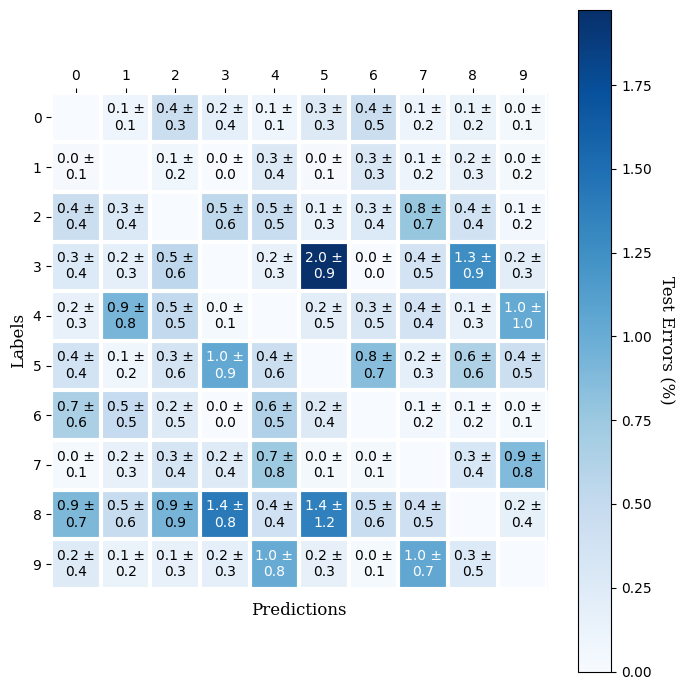

In [14]:
print(f"d* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=2, keepdims=True)
cm_mean = np.mean(confusion_matrix, axis=0); np.fill_diagonal(cm_mean, 0.)
cm_std = np.std(confusion_matrix, axis=0)
labels = np.array([f'{100*mean:.1f} ±\n{100*std:.1f}' for mean, std in zip(cm_mean.flatten(), cm_std.flatten())]).reshape(cm_mean.shape); np.fill_diagonal(labels, '')

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xlabel('Predictions', font='serif', size=12); axs.set_ylabel('Labels', font='serif', size=12)
im, cbar = heatmap(100*cm_mean, np.arange(10), np.arange(10), cbarlabel='Test Errors (%)', ax=axs, cmap='Blues')
texts = annotate_heatmap(im, labels=labels)
fig.tight_layout()
plt.show()

### Question 4

In [15]:
def hardest_samples(kernel, ys, coefs, n=5):

    errors = np.zeros_like(ys)
    for i, y in enumerate(ys):
        predictions = predict(coefs, kernel[i])
        errors[i] = predictions[int(y)]
    hardest_samples = np.argpartition(errors, n)[:n]
    
    return hardest_samples

In [16]:
def plot(img, label, fn=None, show=False):
    
    fig, axs = plt.subplots(figsize=(4, 4))
    img = img.reshape(16, 16)
    axs.imshow(img, cmap='viridis', interpolation='none')
    axs.set_title(f'Label = {label}', fontdict={'font': 'serif', 'size': 16})
    axs.get_xaxis().set_visible(False); axs.get_yaxis().set_visible(False)
    fig.tight_layout()
    if fn is not None:
        fig.savefig(fn)
    if show:
        plt.show()
    else:
        plt.close(fig)

In [17]:
d = np.round(np.mean(results['hparam_star']))
full_kernel_d = full_kernel.kernel(d)

train_indices, test_indices = train_test_split(np.arange(X.shape[0]), train_size=0.8, shuffle=True)
train_kernel, test_kernel = full_kernel_d[np.ix_(train_indices, train_indices)], full_kernel_d[np.ix_(test_indices, train_indices)]
train_y, test_y = Y[train_indices], Y[test_indices]

coefs = init_coefs(n_classifiers, train_indices.size)
coefs, train_mistakes = train(train_kernel, train_y, coefs, n_epochs=n_epochs)
indices = hardest_samples(test_kernel, test_y, coefs, n=5)
hardest_test_samples = test_indices[indices]

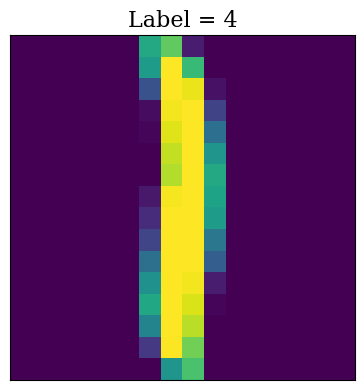

In [18]:
display = 1

dirpath = Path('assets')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
dirpath.mkdir(parents=True, exist_ok=True)

for index in hardest_test_samples:
    img, label = X[index], int(Y[index])
    plot(img, label, fn=f'{dirpath}/sample-{index}_label-{label}.png', show=False)

index = hardest_test_samples[display-1]
img, label = X[index], int(Y[index])
plot(img, label, fn=None, show=True)

### Question 5

In [19]:
class GaussianKernel(BaseKernel):

    def __init__(self, X1, X2=None):
        super().__init__(X1, X2)

    def base_kernel(self, a, b):
        squared_distances = np.sum(np.square(a), axis=1, keepdims=True) + \
            np.sum(np.square(b).T, axis=0, keepdims=True) - \
            2 * a @ b.T
        return squared_distances
    
    def kernel(self, hparam, row_indices=None, col_indices=None):
        indices = self.indices(row_indices, col_indices)
        kernel_matrix = np.exp(-hparam * self.base_kernel_matrix[indices])
        return kernel_matrix
    
full_kernel = GaussianKernel(X)

In [20]:
cs = np.round(np.linspace(0.01, 0.04, num=7, endpoint=True), 3)
error_rates = question_1(n_runs=n_runs, hparams=cs, n_epochs=n_epochs)

df = pd.DataFrame(data=zip(*error_rates.values()), index=cs, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Width')
df

  0%|          | 0/7 [00:00<?, ?it/s]

,Train error (%),Test error (%)
Width,,
0.010,0.322 ± 0.051,3.083 ± 0.405
0.015,0.182 ± 0.055,2.777 ± 0.294
0.020,0.155 ± 0.026,2.761 ± 0.343
0.025,0.149 ± 0.044,2.847 ± 0.421
0.030,0.149 ± 0.046,2.952 ± 0.352
0.035,0.172 ± 0.040,3.169 ± 0.259
0.040,0.192 ± 0.052,3.427 ± 0.443


In [21]:
results, _ = question_2(n_runs=n_runs, n_splits=n_splits, hparams=cs, n_epochs=n_epochs, return_cm=False)

print(f"c* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

c* = 0.021 ± 0.004
Test error (%) = 2.806 ± 0.503


### Question 6

In [22]:
class_combinations = np.array(list(combinations(range(n_classes), 2)))
n_classifiers = class_combinations.shape[0]

classifier_mapping = [[] for _ in range(n_classes)]
for k, (class_a, class_b) in enumerate(class_combinations):
    classifier_mapping[class_a].append(k); classifier_mapping[class_b].append(k)

In [23]:
def train(train_kernel, train_y, coefs, n_epochs=1):

    mistakes = [0 for _ in range(n_epochs)]
    for epoch in range(n_epochs):
        for i in range(train_y.size):
            features, y = train_kernel[i], train_y[i]
            predictions = predict(coefs, features)
            votes = class_combinations[np.arange(n_classifiers), (predictions>0.).astype(int)]
            vote_counts = np.bincount(votes); hard_mx = np.argmax(vote_counts)
            if hard_mx != y:
                mistakes[epoch] += 1
            classifiers = classifier_mapping[int(y)]
            predictions = predictions[classifiers]
            labels = np.full(len(classifiers), -1.); labels[:int(y)] = 1.
            updates = np.where(labels*predictions <= 0., sign(predictions), 0.)
            coefs[classifiers, i] -= updates

    return coefs, mistakes

def test(test_kernel, test_y, coefs, return_cm=False):

    mistakes = 0
    if return_cm:
        confusion_matrix = np.zeros((n_classes, n_classes))
    for i in range(test_y.size):
        features, y = test_kernel[i], test_y[i]
        predictions = predict(coefs, features)
        votes = class_combinations[np.arange(n_classifiers), (predictions>0.).astype(int)]
        vote_counts = np.bincount(votes); hard_mx = np.argmax(vote_counts)
        if hard_mx != y:
            mistakes += 1
        if return_cm:
            confusion_matrix[int(y), hard_mx] += 1

    return mistakes, (confusion_matrix if return_cm else None)


In [24]:
full_kernel = PolynomialKernel(X)

In [25]:
error_rates = question_1(n_runs=n_runs, hparams=ds, n_epochs=n_epochs)

df = pd.DataFrame(data=zip(*error_rates.values()), index=ds, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Degree')
df

  0%|          | 0/7 [00:00<?, ?it/s]

,Train error (%),Test error (%)
Degree,,
1,6.295 ± 0.262,7.766 ± 1.253
2,2.329 ± 0.225,4.551 ± 0.675
3,1.394 ± 0.157,3.685 ± 0.292
4,1.061 ± 0.113,3.728 ± 0.387
5,0.894 ± 0.125,3.613 ± 0.546
6,0.799 ± 0.117,3.503 ± 0.312
7,0.671 ± 0.117,3.651 ± 0.409


In [26]:
results, _ = question_2(n_runs=n_runs, n_splits=n_splits, hparams=ds, n_epochs=n_epochs, return_cm=False)

print(f"d* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

d* = 5.050 ± 1.203
Test error (%) = 3.492 ± 0.289


In [27]:
full_kernel = GaussianKernel(X)

In [28]:
error_rates = question_1(n_runs=n_runs, hparams=cs, n_epochs=n_epochs)

df = pd.DataFrame(data=zip(*error_rates.values()), index=cs, columns=('Train error (%)', 'Test error (%)'))
df.index = df.index.rename('Width')
df

  0%|          | 0/7 [00:00<?, ?it/s]

,Train error (%),Test error (%)
Width,,
0.010,1.146 ± 0.119,4.121 ± 1.714
0.015,0.826 ± 0.106,3.194 ± 0.445
0.020,0.666 ± 0.100,3.594 ± 0.500
0.025,0.633 ± 0.139,3.288 ± 0.320
0.030,0.545 ± 0.097,3.728 ± 0.499
0.035,0.500 ± 0.101,3.855 ± 0.351
0.040,0.506 ± 0.072,4.051 ± 0.492


In [29]:
results, _ = question_2(n_runs=n_runs, n_splits=n_splits, hparams=cs, n_epochs=n_epochs, return_cm=False)

print(f"d* = {np.mean(results['hparam_star']):.3f} ± {np.std(results['hparam_star']):.3f}")
print(f"Test error (%) = {100*np.mean(results['test_error']):.3f} ± {100*np.std(results['test_error']):.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

d* = 0.017 ± 0.004
Test error (%) = 3.425 ± 0.540
